In [1]:
from datasets import load_dataset
import os

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineG

In [3]:
!pip install -U datasets huggingface_hub fsspec

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [4]:
!git lfs install
!git clone https://huggingface.co/datasets/iasminaiacob/disaster-classif

Git LFS initialized.
Cloning into 'disaster-classif'...
remote: Enumerating objects: 13183, done.
remote: Counting objects: 100% (13180/13180), done.
remote: Compressing objects: 100% (13161/13161), done.
remote: Total 13183 (delta 219), reused 0 (delta 0), pack-reused 3 (from 1)
Receiving objects: 100% (13183/13183), 1.90 MiB | 7.45 MiB/s, done.
Resolving deltas: 100% (219/219), done.
Updating files: 100% (12817/12817), done.
Filtering content: 100% (12815/12815), 869.54 MiB | 4.73 MiB/s, done.


In [6]:
#dataloader

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

#load datasets
train_dataset = datasets.ImageFolder('/content/disaster-classif/train', transform=transform)
val_dataset = datasets.ImageFolder('/content/disaster-classif/val', transform=transform)
test_dataset = datasets.ImageFolder('/content/disaster-classif/test', transform=transform)

#create loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Classes: {train_dataset.classes}")
print(f"Train samples: {len(train_dataset)}")
print(f"Evaluation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Classes: ['collapsed_building', 'fire', 'flood', 'no_disaster', 'traffic_accident']
Train samples: 7629
Evaluation samples: 2593
Test samples: 2593


In [7]:
#build model using ResNet

import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


In [8]:
#loss and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
#train
from tqdm import tqdm
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / (len(progress_bar) + 1))
torch.save(model.state_dict(), "disaster_classification_model.pth")

Epoch 1/10


Epoch 1: 100%|██████████| 239/239 [00:43<00:00,  5.52it/s, loss=0.338]


Epoch 2/10


Epoch 2: 100%|██████████| 239/239 [00:41<00:00,  5.74it/s, loss=0.16]


Epoch 3/10


Epoch 3: 100%|██████████| 239/239 [00:41<00:00,  5.74it/s, loss=0.0998]


Epoch 4/10


Epoch 4: 100%|██████████| 239/239 [00:42<00:00,  5.66it/s, loss=0.0894]


Epoch 5/10


Epoch 5: 100%|██████████| 239/239 [00:41<00:00,  5.72it/s, loss=0.0616]


Epoch 6/10


Epoch 6: 100%|██████████| 239/239 [00:42<00:00,  5.67it/s, loss=0.0407]


Epoch 7/10


Epoch 7: 100%|██████████| 239/239 [00:41<00:00,  5.73it/s, loss=0.0575]


Epoch 8/10


Epoch 8: 100%|██████████| 239/239 [00:43<00:00,  5.55it/s, loss=0.0604]


Epoch 9/10


Epoch 9: 100%|██████████| 239/239 [00:41<00:00,  5.73it/s, loss=0.0644]


Epoch 10/10


Epoch 10: 100%|██████████| 239/239 [00:42<00:00,  5.64it/s, loss=0.0257]


In [10]:
#evaluate
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 98.73%


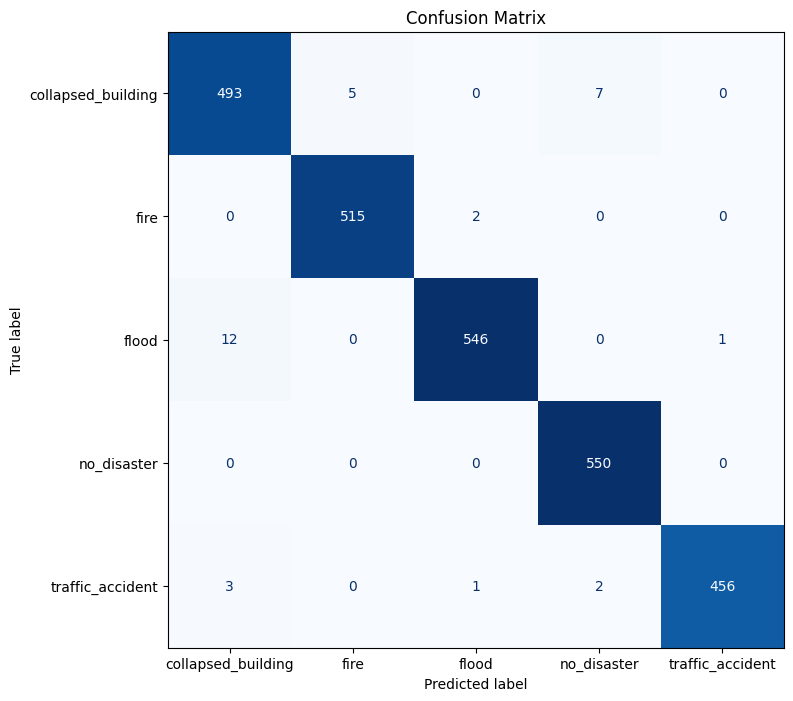

                    precision    recall  f1-score   support

collapsed_building       0.97      0.98      0.97       505
              fire       0.99      1.00      0.99       517
             flood       0.99      0.98      0.99       559
       no_disaster       0.98      1.00      0.99       550
  traffic_accident       1.00      0.99      0.99       462

          accuracy                           0.99      2593
         macro avg       0.99      0.99      0.99      2593
      weighted avg       0.99      0.99      0.99      2593



In [11]:
#confusion matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

class_names = test_loader.dataset.classes

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title('Confusion Matrix')
plt.show()

report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)
